### Cleaned vs Dirty V2
##### Classify if a plate is cleaned or dirty?
тип задачи - классификация \
метрика качества - accuracy(доля правильных ответов) \
transfer learning - дообучение готовой архитектуры 

Основная идея решения - дообучить ResNet 

In [21]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time
import copy

In [22]:
import os
import zipfile

#with zipfile.ZipFile('../input/plates.zip', 'r') as zip_obj:
#    zip_obj.extractall('/kaggle/working/')
#data_root = '/kaggle/working/plates/'

In [23]:
data_root = 'plates/'

Для создания train и validation выборок, создадим и заполним 2 папки:

In [24]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']
#все картинки разбиваются на классы
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)
#каждая 6 картинка помещается в папку validation
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 5290.75it/s]


In [25]:
!ls train

cleaned  dirty


### Предобработка
<b>torchvision.datasets.ImageFolder</b>
 - предоставляет возможность итерирования по изображениям, запомнит в какой папке-классе оно находилось
 - помогает получать изображения в виде тензоров
 
<b>transforms.Compose</b>
 - сжатие картинки до определенного размера
 - превращение ее в тензор
 - от каждого цвета отнимаются константы, т.к. на таких примерах обучался ResNet

In [26]:
import torch
import torchvision

from torchvision import transforms, models

#Аугментации
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224), #вырезается прямоугольная часть и увеличивается до 224
    transforms.RandomHorizontalFlip(), #отзеркаливание
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

In [27]:
#num_workers - количество потоков выполняющих трансформации
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

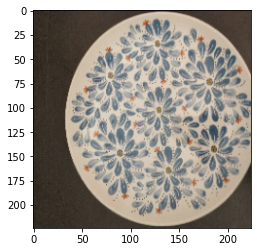

In [31]:
X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);